In [126]:
import pandas as pd
import os
from project.dataset import Dataset, VALDODataset
from project.preprocessing import z_score_normalization, min_max_normalization, NiftiToTensorTransform
from project.training import split_train_val_datasets
from project.utils import collate_fn, plot_all_slices, plot_all_slices_from_array
from torch.utils.data import DataLoader
import torch
from project.model import VisionTransformer
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F

In [127]:
d_model = 2
n_classes = 2
img_size = (16,16)
patch_size = (2,2)
n_channels = 1
n_heads = 2
n_layers = 3
batch_size = 1
epochs = 1
alpha = 0.000125

In [128]:
ds = Dataset()

In [129]:
# masks = ds.load_cmb_masks()
# cases = ds.load_raw_mri()
# cases = ds.load_skullstripped_mri()

masks = ds.load_cmb_masks(cohort_num=1)
cases = ds.load_raw_mri(cohort_num=1)

In [130]:
transform = NiftiToTensorTransform(target_shape=(512,512))

In [131]:
dataset = VALDODataset(
    cases=cases, 
    masks=masks, 
    transform=transform,
    normalization=z_score_normalization
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [132]:
sample_output = [
    
]

#1asdf

In [133]:
print(type(dataset))
print(len(dataset))

<class 'project.dataset.valdo.VALDODataset'>
11


In [134]:
has_cmb = [1 if count > 0 else 0 for count in dataset.cmb_counts]

df_dataset = pd.DataFrame({
    'MRI Scans': dataset.cases,
    'Segmented Masks': dataset.masks,
    'CMB Count': dataset.cmb_counts,
    'Has CMB': has_cmb
})

In [135]:
train_dataset, val_dataset = split_train_val_datasets(
    df=df_dataset, 
    transform=transform
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [136]:
train_loader = DataLoader(
    train_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    val_dataset, 
    shuffle=True, 
    batch_size=batch_size,
    collate_fn=collate_fn
)

In [137]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [138]:
transformer = VisionTransformer(
    D_model=d_model,
    N_classes=n_classes,
    Img_size=img_size,
    Patch_size=patch_size,
    N_channels=n_channels,
    N_heads=n_heads,
    N_layers=n_layers,
    device=device
)

In [139]:
transformer = transformer.to(device)

In [140]:
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

In [141]:
import matplotlib.pyplot as plt
def print_image(img, title):
    plt.imshow(img, cmap='hot')
    plt.title(title)
    plt.show()

In [142]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import re 
for epoch in range(epochs):
    training_loss = 0.0 
    progress_bar = tqdm(
        enumerate(train_loader, 0),
        total=len(train_loader),
        desc=f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}'
    )
    for i, data in progress_bar: 
        if torch.unique(data[1]).numel() > 1:  # If the case has a CMB then it will run
            num_slices = len(data[1]) # Number of slices
            case_number = re.search(r'sub-(\d+)', data[2][0]).group(1) # Extract the case number
            print(f'Case: {case_number}')
            if num_slices != len(data[0]):
                print('Not equal Number of slices:', num_slices, data[0]) #Checks if the number of slices of the MRI and the mask are the same
                break
            for j in range(num_slices):
                bounding_boxes = dataset.extract_bounding_boxes(data[1][j][0].numpy()) #Extracts all the bounding boxes of the slice 
                cropped_images = []
                cropped_labels = []
                coordinates = []
                if len(bounding_boxes) <= 0: # If there are no bounding boxes then it will skip the slice
                    print('No bounding boxes found on slice ', j)
                    continue
                for bbox in bounding_boxes: # For each bounding box it will crop the image and the label based on the given coordinates
                    print(f"Slice {j} | ", bbox) 
                    print(data[0][j][0].shape)
                    cropped_images.append(
                        dataset.get_cropped_locations(
                            img = data[0], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    cropped_labels.append(
                        dataset.get_cropped_locations(
                            img = data[1], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    coordinates.append(bbox)
                
                if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]): ## Checks if the number of cropped images and labels are the same
                    print('Not equal cropped images and labels')
                    break

                    # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                print('Cropped Images length:', len(cropped_images))
                print('Cropped Labels length:', len(cropped_labels))
                print('Cropped Images number of slices:', len(cropped_images[0][0][0])) # This is the MRI image of the CMB with the coordinate
                print('Cropped Labels number of slices:', len(cropped_labels[0][0])) # This is the mask of the CMB with the coordinate
                for k, cmb in enumerate(cropped_labels[0]): # Access the CMB labels array the n checks if there are CMBs on the slice of the case 
                    for l, cmb_slice in enumerate(cmb):
                        # print(cmb_slice.shape)
                        if torch.unique(cmb_slice).numel() > 1:
                            print('Multiple classes found on silce: ', l)
                            print(cmb_slice.shape)
                            print(cropped_images[0][0][0][l].shape)
                            # Enable ths method to visually see what is feeded on the model 
                            # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            print(f'Learning on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            optimizer.zero_grad()
                            inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                            labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                            print("Feeded inputs shape: ",inputs.shape)
                            print("Feeded mask shape: ",labels.shape)
                            outputs = transformer(inputs.float(), labels.float())
                            loss = criterion(outputs, labels.long())  
                            print("Output shape: ",outputs.shape)
                            loss.backward()
                            optimizer.step()
                            training_loss += loss.item()
                            print(f'Loss: {loss.item()}')
            print("Training Loss: ", training_loss)      
        else:
            print('Skipping...')
            continue
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}')
print('Final training loss:', training_loss)
print('Finished Training')
        
        

Epoch 1/1 loss: 0.000:   0%|          | 0/8 [00:00<?, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 101
No bounding boxes found on slice  0
No bounding boxes found on slice  1
No bounding boxes found on slice  2
No bounding boxes found on slice  3
No bounding boxes found on slice  4
No bounding boxes found on slice  5
No bounding boxes found on slice  6
No bounding boxes found on slice  7
Slice 8 |  [164, 327, 172, 336]
torch.Size([1, 512, 512])
Slice 8 |  [180, 299, 184, 303]
torch.Size([1, 512, 512])
Cropped Images length: 2
Cropped Labels length: 2
Cropped Images number of slices: 35
Cropped Labels number of slices: 35
Multiple classes found on silce:  8
torch.Size([16, 16])
torch.Size([16, 16])
Learning on Case 101 Slice 8 CMB coordinates [164, 327, 172, 336]
Feeded inputs shape:  torch.Size([1, 1, 16, 16])
Feeded mask shape:  torch.Size([1, 16, 16])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.8936, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
O

Epoch 1/1 loss: 0.000:  12%|█▎        | 1/8 [00:00<00:04,  1.59it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Loss: 1.597661018371582
No bounding boxes found on slice  18
No bounding boxes found on slice  19
No bounding boxes found on slice  20
No bounding boxes found on slice  21
No bounding boxes found on slice  22
No bounding boxes found on slice  23
No bounding boxes found on slice  24
No bounding boxes found on slice  25
No bounding boxes found on slice  26
Slice 27 |  [254, 303, 258, 308]
torch.Size([1, 512, 512])
Cropped Images length: 1
Cropped Labels length: 1
Cropped Images number of slices: 35
Cropped Labels number of slices: 35
Multiple classes found on silce:  27
torch.Size([16, 16])
torch.Size([16, 16])
Learning on Case 101 Slice 27 CMB coordinates [254, 303, 258, 308]
Feeded inputs shape:  torch.Size([1, 1, 16, 16])
Feeded mask shape:  torch.Size([1, 16, 16])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.0265, device='cuda:0', grad_fn=<NllLoss2DBackward0

Epoch 1/1 loss: 0.000:  25%|██▌       | 2/8 [00:01<00:03,  1.74it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 111
No bounding boxes found on slice  0
No bounding boxes found on slice  1
No bounding boxes found on slice  2
No bounding boxes found on slice  3
No bounding boxes found on slice  4
No bounding boxes found on slice  5
No bounding boxes found on slice  6
No bounding boxes found on slice  7
No bounding boxes found on slice  8
Slice 9 |  [263, 338, 267, 343]
torch.Size([1, 512, 512])
Cropped Images length: 1
Cropped Labels length: 1
Cropped Images number of slices: 35
Cropped Labels number of slices: 35
Multiple classes found on silce:  9
torch.Size([16, 16])
torch.Size([16, 16])
Learning on Case 111 Slice 9 CMB coordinates [263, 338, 267, 343]
Feeded inputs shape:  torch.Size([1, 1, 16, 16])
Feeded mask shape:  torch.Size([1, 16, 16])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.9843, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Output shape:  torch.Si

Epoch 1/1 loss: 0.000:  38%|███▊      | 3/8 [00:01<00:02,  1.98it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 102
No bounding boxes found on slice  0
No bounding boxes found on slice  1
No bounding boxes found on slice  2
No bounding boxes found on slice  3
No bounding boxes found on slice  4
No bounding boxes found on slice  5
No bounding boxes found on slice  6
No bounding boxes found on slice  7
No bounding boxes found on slice  8
No bounding boxes found on slice  9
No bounding boxes found on slice  10
No bounding boxes found on slice  11
No bounding boxes found on slice  12
No bounding boxes found on slice  13
No bounding boxes found on slice  14
No bounding boxes found on slice  15
No bounding boxes found on slice  16
Slice 17 |  [246, 316, 255, 325]
torch.Size([1, 512, 512])
Cropped Images length: 1
Cropped Labels length: 1
Cropped Images number of slices: 35
Cropped Labels number of slices: 35
Multiple classes found on silce:  17
torch.Size([16, 16])
torch.Size([16, 16])
Learning on Case 102 Slice 17 CMB coordinates [246, 316, 255, 325]
Feeded inputs shape:  torch.Size([1, 1, 16, 

Epoch 1/1 loss: 0.000:  50%|█████     | 4/8 [00:02<00:01,  2.12it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Skipping...


Epoch 1/1 loss: 0.000:  62%|██████▎   | 5/8 [00:02<00:01,  1.91it/s]

Case: 103
No bounding boxes found on slice  0
No bounding boxes found on slice  1
No bounding boxes found on slice  2
No bounding boxes found on slice  3
No bounding boxes found on slice  4
Slice 5 |  [132, 278, 138, 283]
torch.Size([1, 512, 512])
Cropped Images length: 1
Cropped Labels length: 1
Cropped Images number of slices: 35
Cropped Labels number of slices: 35
Multiple classes found on silce:  5
torch.Size([16, 16])
torch.Size([16, 16])
Learning on Case 103 Slice 5 CMB coordinates [132, 278, 138, 283]
Feeded inputs shape:  torch.Size([1, 1, 16, 16])
Feeded mask shape:  torch.Size([1, 16, 16])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.2757, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Output shape:  torch.Size([1, 2, 16, 16])
Loss: 1.275747537612915
No bounding boxes found on slice  6
No bounding boxes found on slice  7
No bounding boxes found on sl

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Epoch 1/1 loss: 0.000:  75%|███████▌  | 6/8 [00:03<00:00,  2.02it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 106
No bounding boxes found on slice  0
No bounding boxes found on slice  1
No bounding boxes found on slice  2
No bounding boxes found on slice  3
No bounding boxes found on slice  4
No bounding boxes found on slice  5
No bounding boxes found on slice  6
No bounding boxes found on slice  7
No bounding boxes found on slice  8
No bounding boxes found on slice  9
No bounding boxes found on slice  10
Slice 11 |  [85, 308, 89, 312]
torch.Size([1, 512, 512])
Cropped Images length: 1
Cropped Labels length: 1
Cropped Images number of slices: 35
Cropped Labels number of slices: 35
Multiple classes found on silce:  11
torch.Size([16, 16])
torch.Size([16, 16])
Learning on Case 106 Slice 11 CMB coordinates [85, 308, 89, 312]
Feeded inputs shape:  torch.Size([1, 1, 16, 16])
Feeded mask shape:  torch.Size([1, 16, 16])
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.7102

Epoch 1/1 loss: 0.000:  88%|████████▊ | 7/8 [00:03<00:00,  2.22it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Skipping...


Epoch 1/1 loss: 0.000: 100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

Case: 108
No bounding boxes found on slice  0
No bounding boxes found on slice  1
No bounding boxes found on slice  2
No bounding boxes found on slice  3
No bounding boxes found on slice  4
No bounding boxes found on slice  5
No bounding boxes found on slice  6
No bounding boxes found on slice  7
No bounding boxes found on slice  8
No bounding boxes found on slice  9
No bounding boxes found on slice  10
No bounding boxes found on slice  11
No bounding boxes found on slice  12
No bounding boxes found on slice  13
No bounding boxes found on slice  14
Slice 15 |  [273, 292, 277, 297]
torch.Size([1, 512, 512])
Slice 15 |  [277, 228, 280, 232]
torch.Size([1, 512, 512])
Slice 15 |  [268, 220, 272, 224]
torch.Size([1, 512, 512])
Cropped Images length: 3
Cropped Labels length: 3
Cropped Images number of slices: 35
Cropped Labels number of slices: 35
Multiple classes found on silce:  15
torch.Size([16, 16])
torch.Size([16, 16])
Learning on Case 108 Slice 15 CMB coordinates [273, 292, 277, 297]


Epoch 1/1 loss: 0.000: 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

Epoch 1/1 loss: 8.786
Final training loss: 70.28869807720184
Finished Training


In [143]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)

In [144]:
dir_path = 'experiments'

if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
file_num = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
torch.save(transformer.state_dict(), f'experiments/ViT{file_num + 1}.pth')

In [145]:
transformer.to(device)
transformer.load_state_dict(torch.load(f"Experiments/ViT{file_num+1}.pth"))
transformer.eval()

VisionTransformer(
  (patch_embedding): PatchEmbedding(
    (linear_project): Conv2d(1, 2, kernel_size=(2, 2), stride=(2, 2))
  )
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): Sequential(
    (0): TransformerEncoder(
      (ln1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_o): Linear(in_features=2, out_features=2, bias=True)
        (heads): ModuleList(
          (0-1): 2 x AttentionHead(
            (query): Linear(in_features=2, out_features=1, bias=True)
            (key): Linear(in_features=2, out_features=1, bias=True)
            (value): Linear(in_features=2, out_features=1, bias=True)
          )
        )
      )
      (ln2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=8, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=8, out_features=2, bias=True)
      )
    )
    (1): TransformerEncoder

In [146]:
def predict(model, image, mask):
    model.eval()
    
    with torch.no_grad():
        image = image.to(device)
        output = model(images = image, mask = mask)
        output = F.interpolate(output, size=img_size, mode='bilinear', align_corners=False)
        prediction = torch.argmax(output, dim=1)
        
    return prediction.cpu().numpy()

In [147]:
for i, data in enumerate(test_loader):
    print(data)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


(tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        ...,



        [[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

In [148]:
val_loss = 0.0
length = len(test_loader)
case = 0 
predictions = []
with torch.no_grad():
    for i, val_batch in tqdm(enumerate(test_loader, 0)):
        num_slices = len(val_batch[1])#Number of slces
        one_case = []#This is where we store every slice of the case 
        case_number = re.search(r'sub-(\d+)', val_batch[2][0]).group(1) # Extract the case number
        one_case.append(case_number)
        slice_list = []

        # slices_images = [] #This is where we store the images of the slices
        # slices_predictions = [] #This is where we store the predictions of the slices
        # slices_true_labels = [] #This is where we store the true labels of the slices

        print(f'Case: {case_number}')
        if num_slices != len(val_batch[0]):
            print('Not equal Number of slices:', num_slices, val_batch[0])#Checks if the number of slices of the MRI and the mask are the same
            break
        for j in range(num_slices):
            prediction_data = []#This is where we store the data of the slice predictions that will be appended to the slices_predictions list
            slice_data = []
            bounding_boxes = dataset.extract_bounding_boxes(val_batch[1][j][0].numpy())#Extracts all the bounding boxes of the slice
            cropped_images = []
            cropped_labels = []
            coordinates = []
            if len(bounding_boxes) > 0: # If there are no bounding boxes then it will skip the slice
                print('No bounding boxes found on slice ', j)
                
                for bbox in bounding_boxes: #For each bounding box it will crop the image and the label based on the given 
                    print(f"Slice {j} | ", bbox)
                    print(val_batch[0][j][0].shape)
                    cropped_images.append(
                        dataset.get_cropped_locations(
                            img = val_batch[0], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    cropped_labels.append(
                        dataset.get_cropped_locations(
                            img = val_batch[1], 
                            x_min=bbox[0],
                            y_min=bbox[1],
                            x_max=bbox[2],
                            y_max=bbox[3]
                        ))
                    coordinates.append(bbox)
                if len(cropped_images[0][0][0]) != len(cropped_labels[0][0]):## Checks if the number of cropped images and labels are the same
                    print('Not equal cropped images and labels')
                    break
                # TODO: Improve this method since the method requires all the slices therefore it is needed to have another loop that checks if the extracted region has a cmb or not before feeding it into the model
                # print('Cropped Images length:', len(cropped_images))
                # print('Cropped Labels length:', len(cropped_labels))
                # print('Cropped Images number of slices:', len(cropped_images[0][0][0]))
                # print('Cropped Labels number of slices:', len(cropped_labels[0][0]))
                for k, cmb in enumerate(cropped_labels[0]):# Access the CMB labels array the n checks if there are CMBs on the slice of the case
                    for l, cmb_slice in enumerate(cmb):
                        if torch.unique(cmb_slice).numel() > 1:
                            one_cmb = []
                            # print('Predicting CMB with coordinates: ', coordinates[k])
                            # print(cmb_slice.shape)
                            # print(cropped_images[0][0][0][l].shape)
                            
                            # Enable ths method to visually see what is feeded on the model
                            # print_image(cropped_images[0][0][0][l], f'MRI Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            print(f'Predicting on Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            inputs = cropped_images[0][0][0][l].unsqueeze(0).unsqueeze(0).to(device)
                            labels = cropped_labels[0][0][l].unsqueeze(0).to(device)
                            # print("Feeded inputs shape: ",inputs.shape)
                            # print("Feeded mask shape: ",labels.shape)
                            predicted_mask = predict(transformer, image = inputs.float(), mask = labels.float())
                            # print("Output shape: ",predicted_mask.shape)

                            one_cmb.append(predicted_mask[0])
                            one_cmb.append(cmb_slice)
                            one_cmb.append(coordinates[k])
                            prediction_data.append(one_cmb)
                            # print_image(predicted_mask[0], f'Predicted Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')
                            # print_image(cmb_slice, f'Ground Truth Mask Case {case_number} Slice {l} CMB coordinates {coordinates[k]}')

            slice_data.append(j)
            slice_data.append(val_batch[0][j][0])
            slice_data.append(prediction_data)
            slice_data.append(val_batch[1][j][0])
            slice_list.append(slice_data)
            
            print("image shape append: ", val_batch[0][j].shape)
        # print("Images", slices_images)
        # print("Appended images: ", len(slices_images))

        one_case.append(slice_list)
        predictions.append(one_case)



0it [00:00, ?it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
1it [00:00,  2.89it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 107
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  13
Slice 13 |  [154, 205, 157, 209]
torch.Size([1, 512, 512])
Predicting on Case 107 Slice 13 CMB coordinates [154, 205, 157, 209]
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.37

2it [00:00,  3.07it/s]pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


Case: 109
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 512, 512])
image shape append:  torch.Size([1, 1, 5

3it [00:01,  2.07it/s]

Slice 30 |  [125, 221, 128, 225]
torch.Size([1, 512, 512])
Predicting on Case 110 Slice 30 CMB coordinates [150, 297, 154, 302]
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(1.7699, device='cuda:0')
image shape append:  torch.Size([1, 1, 512, 512])
No bounding boxes found on slice  31
Slice 31 |  [166, 231, 170, 235]
torch.Size([1, 512, 512])
Slice 31 |  [139, 227, 142, 231]
torch.Size([1, 512, 512])
Slice 31 |  [136, 222, 139, 225]
torch.Size([1, 512, 512])
Slice 31 |  [171, 221, 176, 227]
torch.Size([1, 512, 512])
Slice 31 |  [132, 218, 135, 221]
torch.Size([1, 512, 512])
Predicting on Case 110 Slice 28 CMB coordinates [166, 231, 170, 235]
Input shape before classification: torch.Size([1, 65, 2])
Shape after reshaping: torch.Size([1, 2, 8, 8])
Shape after upsampling: torch.Size([1, 2, 16, 16])
Loss:  tensor(2.9394, device='cuda:0')
Predicting on Case 110 Slice 

In [149]:
import torch
import matplotlib.pyplot as plt

def overlay_mask(image, mask, coordinates):
    x1, y1, x2, y2 = coordinates
    resized_mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(y2-y1, x2-x1), mode='nearest').squeeze()

    mask_overlay = torch.zeros_like(image)
    mask_overlay[y1:y2, x1:x2] = resized_mask

    return image, mask_overlay

def show_image(image, mask_overlay, title):
    plt.imshow(image, cmap='gray') 
    plt.imshow(mask_overlay, cmap='hot', alpha=0.5)  
    plt.title(title)
    plt.axis('off')
    plt.show()


### Switch p for predicted and t for true mask

In [150]:
mask_type = 'p'
# mask_type = 't'

------------Case 107---------------
Length of the whole case:  2
Case number 107
Number of slices:  35
================Case 107 Slice 0================
Slice 0
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 1================
Slice 1
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 2================
Slice 2
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 3================
Slice 3
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 4================
Slice 4
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 5================
Slice 5
Image shape:  torch.Size([1, 512, 5

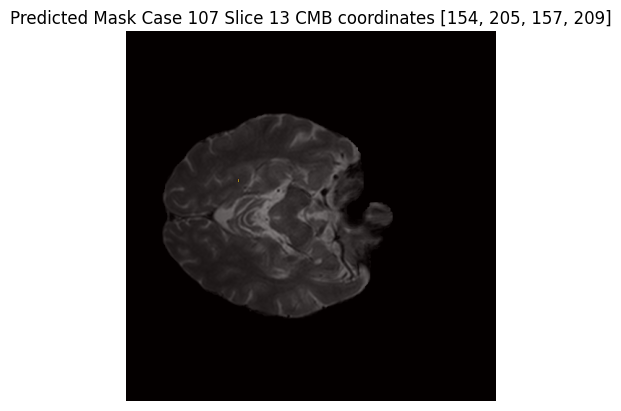

================Case 107 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

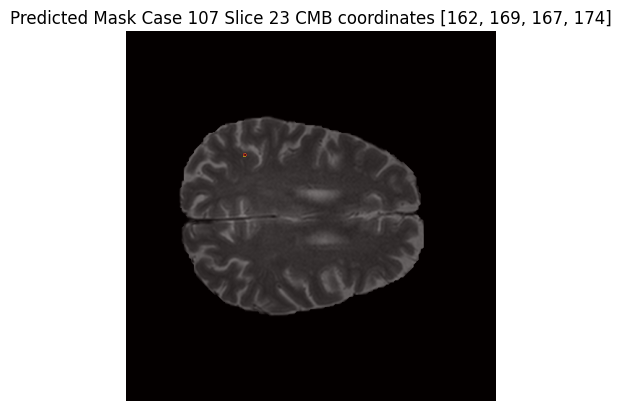

================Case 107 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 107 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 1

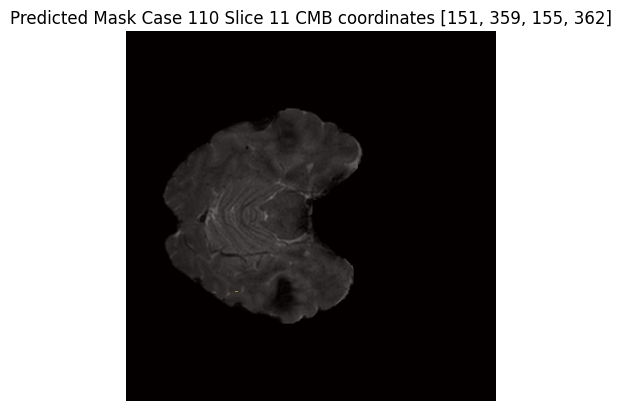

================Case 110 Slice 12================
Slice 12
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 13================
Slice 13
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 14================
Slice 14
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [95, 235, 100, 239]


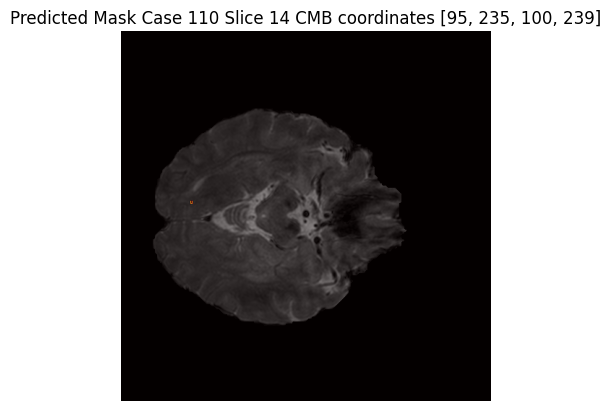

================Case 110 Slice 15================
Slice 15
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 16================
Slice 16
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 17================
Slice 17
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 18================
Slice 18
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [241, 309, 245, 313]


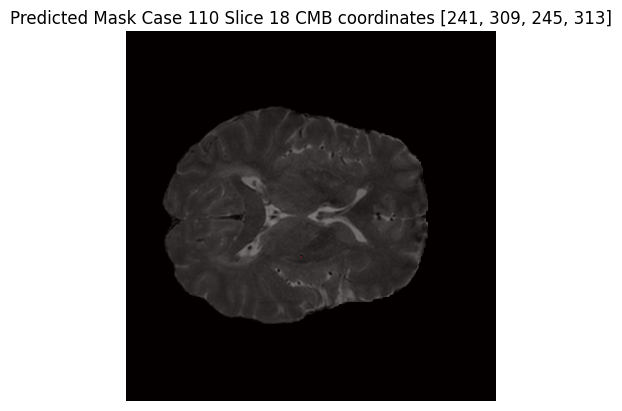

================Case 110 Slice 19================
Slice 19
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [85, 230, 91, 236]


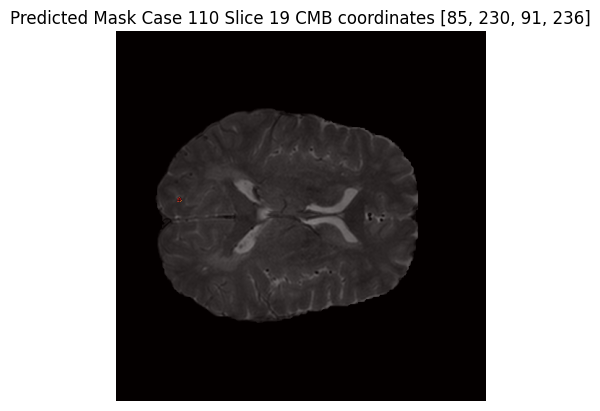

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [85, 230, 91, 236]


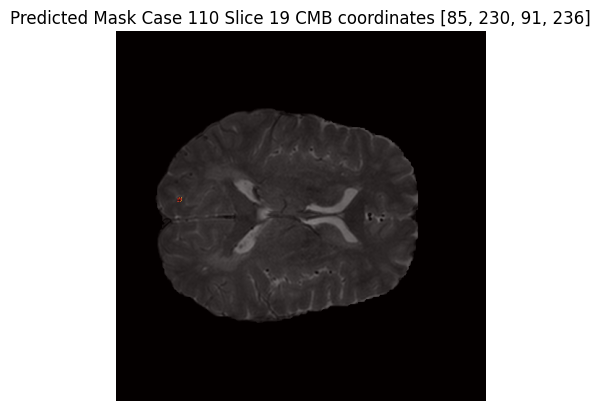

================Case 110 Slice 20================
Slice 20
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [93, 311, 97, 315]


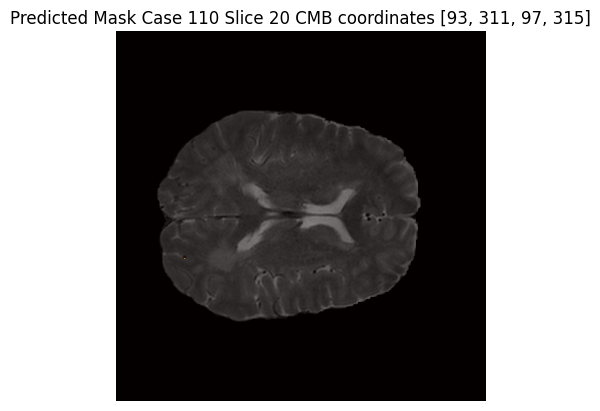

================Case 110 Slice 21================
Slice 21
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [82, 312, 86, 316]


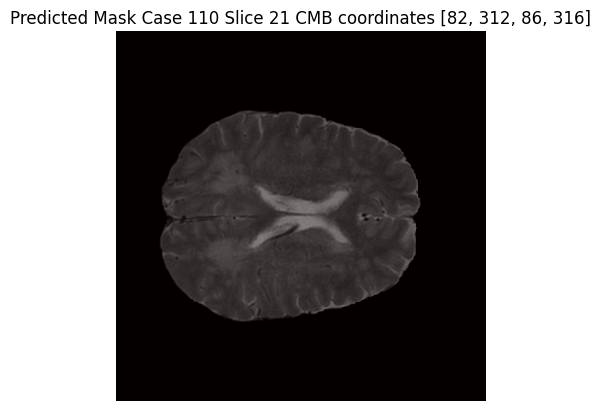

================Case 110 Slice 22================
Slice 22
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [177, 223, 181, 228]


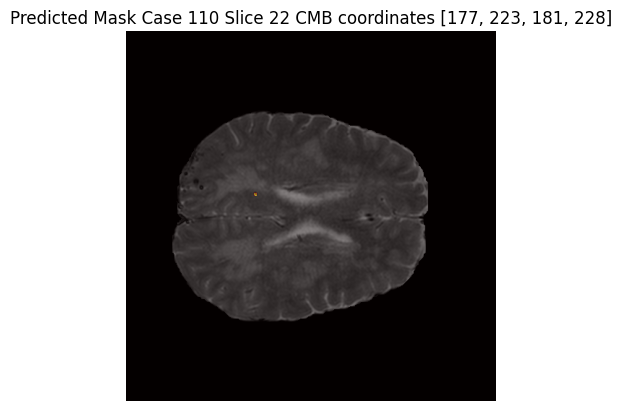

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [177, 223, 181, 228]


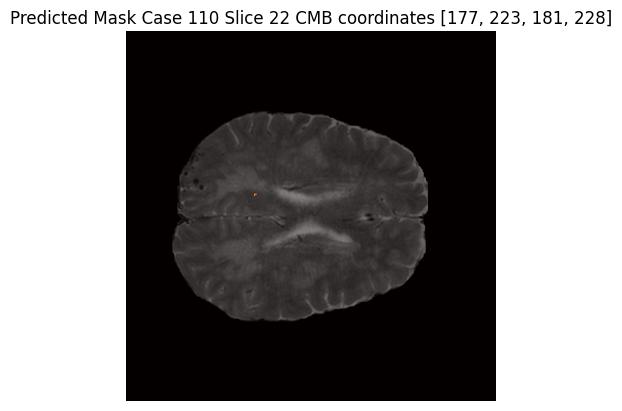

================Case 110 Slice 23================
Slice 23
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [182, 234, 186, 239]


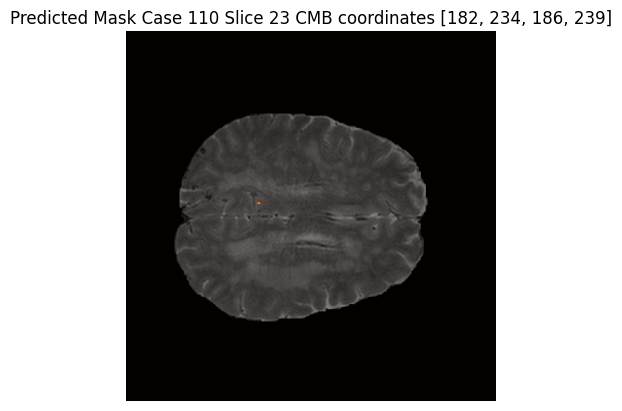

================Case 110 Slice 24================
Slice 24
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [114, 247, 118, 251]


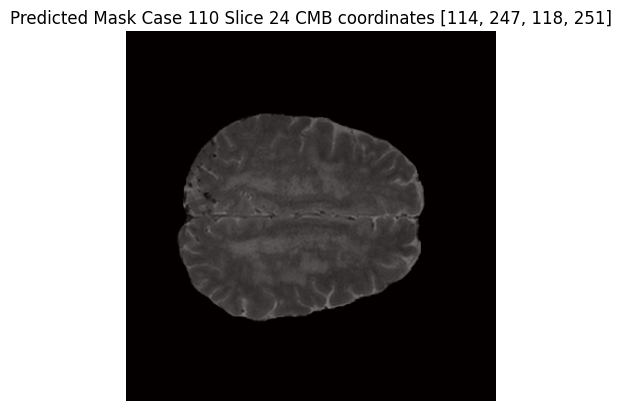

================Case 110 Slice 25================
Slice 25
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [99, 321, 103, 325]


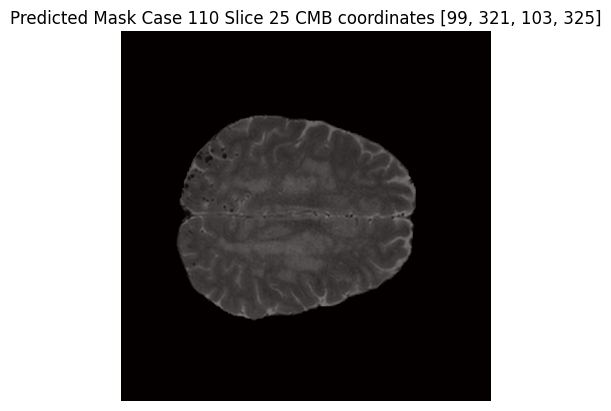

================Case 110 Slice 26================
Slice 26
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [118, 237, 122, 240]


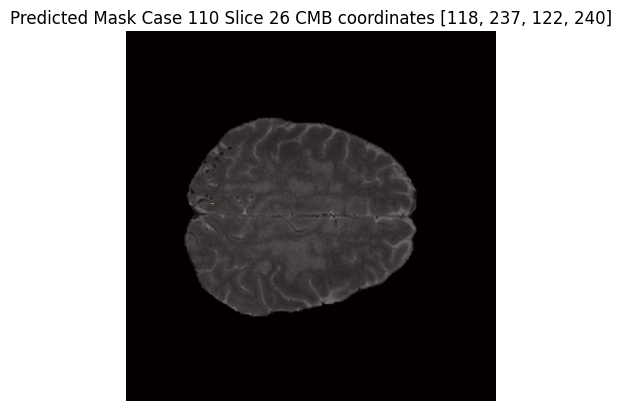

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [118, 237, 122, 240]


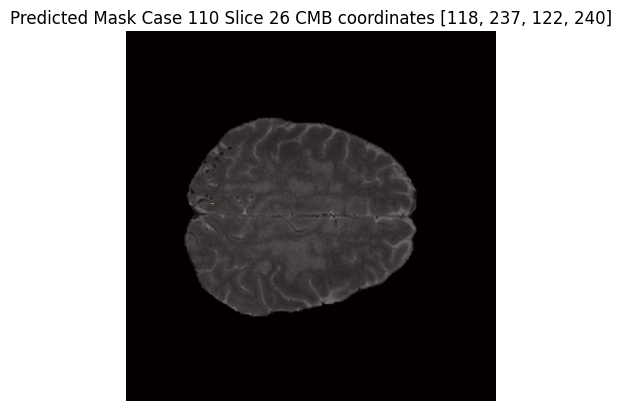

================Case 110 Slice 27================
Slice 27
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [117, 297, 121, 302]


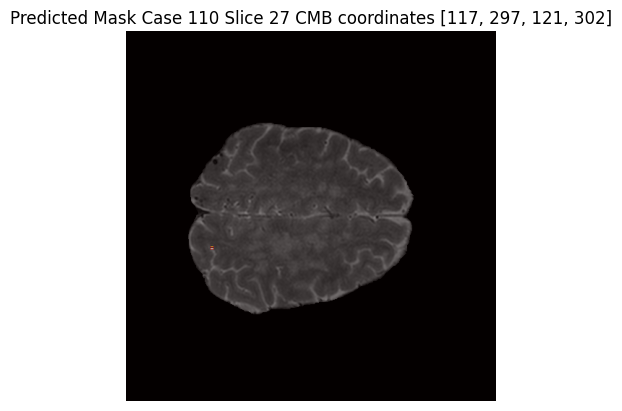

================Case 110 Slice 28================
Slice 28
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [169, 245, 173, 249]


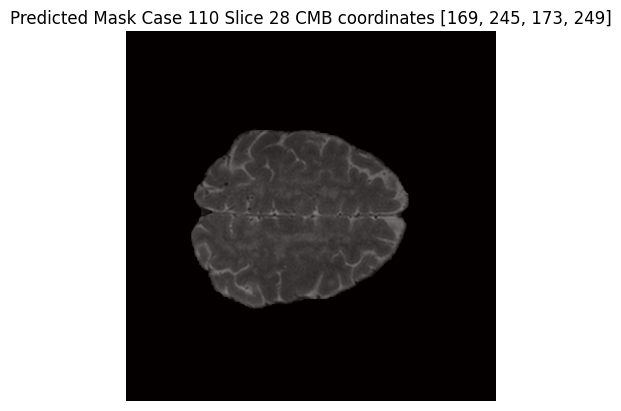

================Case 110 Slice 29================
Slice 29
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [141, 232, 145, 236]


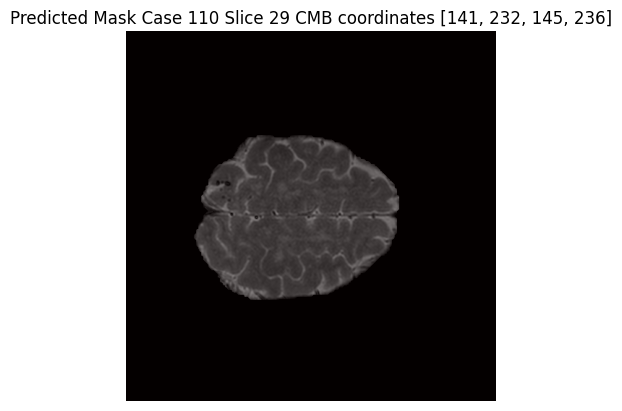

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [141, 232, 145, 236]


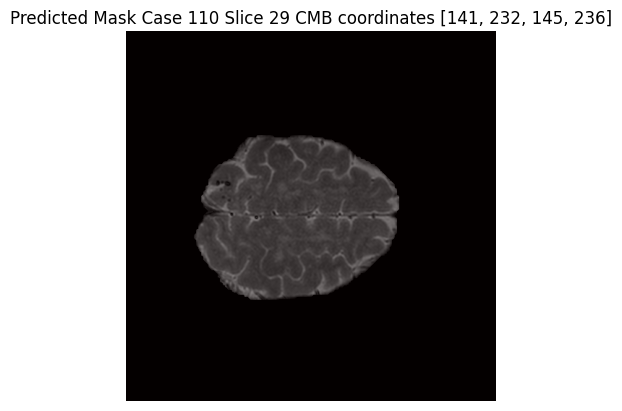

================Case 110 Slice 30================
Slice 30
Image shape:  torch.Size([1, 512, 512])
Prediction length:  1
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [150, 297, 154, 302]


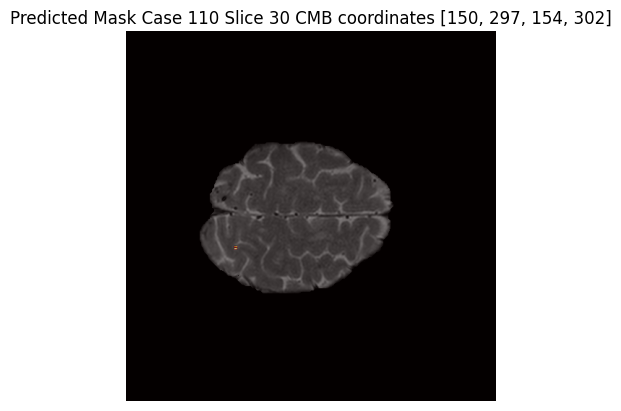

================Case 110 Slice 31================
Slice 31
Image shape:  torch.Size([1, 512, 512])
Prediction length:  2
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 231, 170, 235]


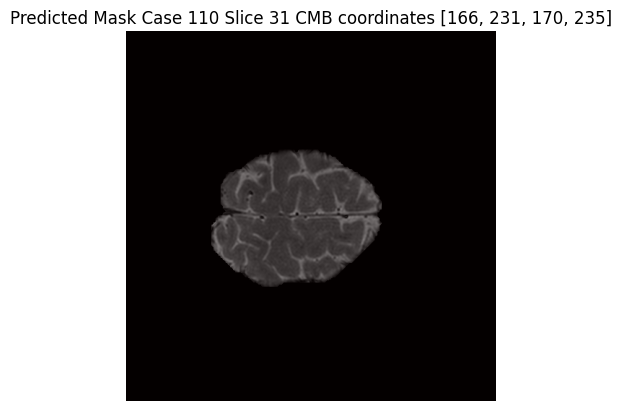

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [166, 231, 170, 235]


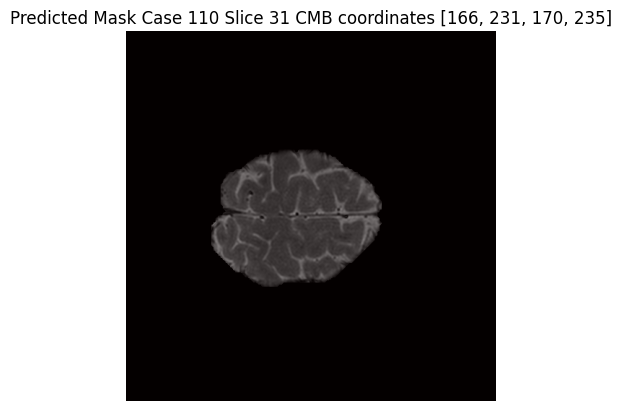

================Case 110 Slice 32================
Slice 32
Image shape:  torch.Size([1, 512, 512])
Prediction length:  4
True label shape:  torch.Size([512, 512])
Prediction 0
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


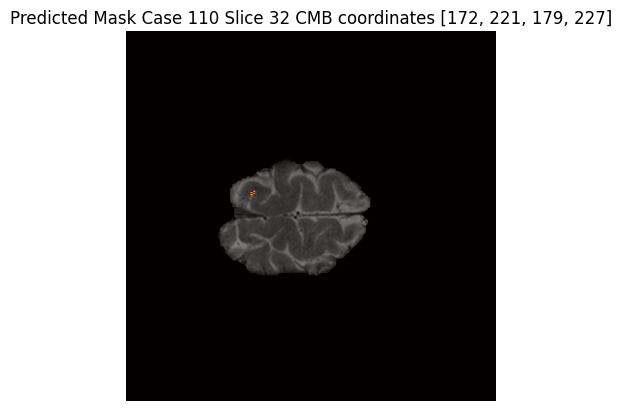

Prediction 1
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


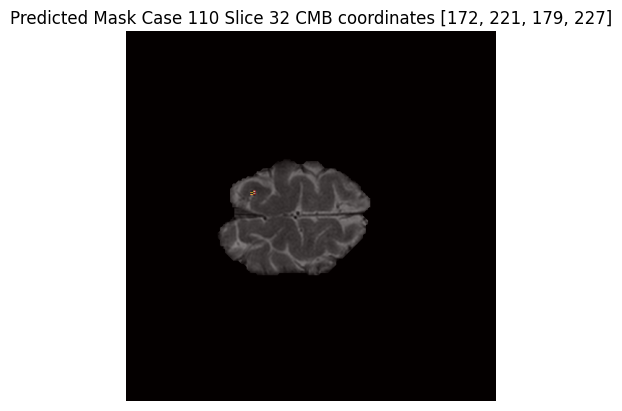

Prediction 2
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


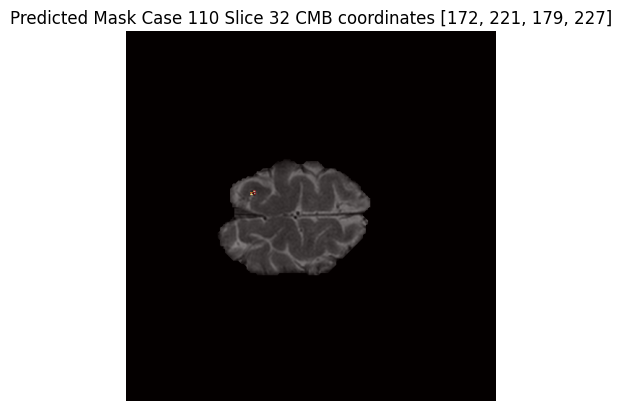

Prediction 3
Predicted Mask shape:  (16, 16)
True Mask shape:  torch.Size([16, 16])
Coordinates:  [172, 221, 179, 227]


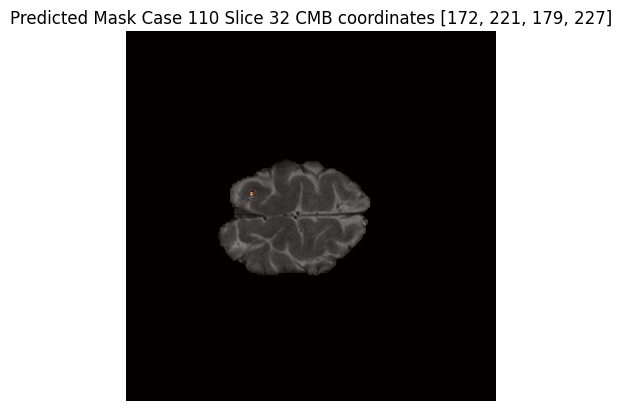

================Case 110 Slice 33================
Slice 33
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])
================Case 110 Slice 34================
Slice 34
Image shape:  torch.Size([1, 512, 512])
Prediction length:  0
True label shape:  torch.Size([512, 512])


In [151]:
for case in predictions:
    case_number = case[0]
    print(f"------------Case {case_number}---------------")
    print("Length of the whole case: ", len(case))
    print("Case number", case[0])
    print("Number of slices: ", len(case[1]))

    for i, case_slice in enumerate(case[1]):
        slice_number = case_slice[0]
        print(f"================Case {case_number} Slice {slice_number}================")
        print(f"Slice {slice_number}")
        print("Image shape: ", case_slice[1].shape)
        print("Prediction length: ", len(case_slice[2]))
        print("True label shape: ", case_slice[3].shape)
        slice_image = case_slice[1][0]
        slice_prediction = case_slice[2]
        # Assuming your slice_prediction contains multiple masks
        for j, slice_pred in enumerate(slice_prediction):
            print(f"Prediction {j}")
            print("Predicted Mask shape: ", slice_pred[0].shape)
            print("True Mask shape: ", slice_pred[1].shape)
            print("Coordinates: ", slice_pred[2])
            
            predicted_mask = slice_pred[0]  
            true_mask = slice_pred[1]       
            coordinates = slice_pred[2]     
            

            predicted_mask = torch.tensor(predicted_mask, dtype=torch.float32)
            
   
            image_slice = slice_image
            
            
            if mask_type == 'p':
                image, mask_overlay = overlay_mask(image_slice, predicted_mask, coordinates)
                show_image(image, mask_overlay, f'Predicted Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            elif mask_type == 't':
                image, mask_overlay = overlay_mask(image_slice, true_mask, coordinates)
                show_image(image, mask_overlay, f'True Mask Case {case_number} Slice {slice_number} CMB coordinates {coordinates}')
            else:
                print("Invalid input! Skipping this slice.")
    # break

In [152]:
import winsound

# Frequency (Hz) and duration (ms)
frequency = 1000  # Set frequency to 1000 Hz
duration = 500    # Set duration to 500 ms

# Play the sound
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)
winsound.Beep(frequency, duration)


In [153]:
# val_loss = 0.0
# predicted = []

# length = len(test_loader)
# case = 0 
# with torch.no_grad():
#     for i, val_batch in tqdm(enumerate(test_loader, 0)):
#         # num_slices = len(val_batch[0])
#         val_slices = []
#         one_case = []
#         val_masks = []

#         cropped_images = dataset.get_cropped_locations(img=val_batch[0], x_min=160, y_min=324, x_max=176, y_max=340)
#         cropped_labels = dataset.get_cropped_locations(img=val_batch[1], x_min=160, y_min=324, x_max=176, y_max=340)

#         num_slices = len(cropped_images)
#         for j in range(num_slices):
#             print(f'Predicting case {i} slice {j}')
#             val_images = cropped_images[j].unsqueeze(0).unsqueeze(0).float().to(device)
#             val_mask = cropped_labels[j].unsqueeze(0).float().to(device) 
            
#             predicted_mask = predict(transformer, val_images)
 
#             predicted_mask = torch.from_numpy(predicted_mask).unsqueeze(1).to(device).float()
#             predicted_mask = F.interpolate(
#                 predicted_mask, 
#                 size=img_size, 
#                 mode='nearest'
#             ).squeeze(1)

#             val_loss += criterion(predicted_mask, val_mask).item() 
#             val_slices.append(predicted_mask)
#             val_masks.append(val_mask)
            
#             print('Loss:', val_loss)
#         one_case.append(val_slices)
#         one_case.append(val_masks)
#         predicted.append(one_case)
#         case += 1

# print(f' Final Validation Loss: {val_loss}')

In [154]:
# plot_all_slices_from_array(predicted, case_index=14)

In [155]:
# plot_all_slices(masks[1])